# 08c_LSOA_Endoscopy_Access_Classification.ipynb

## Objective
This notebook calculates the endoscopy room accessibility per LSOA across the NHS South West region. It classifies access levels based on the number of endoscopy rooms reachable within a 90-minute travel window (car), standardised per 100,000 residents aged 50–74.

## Classification Thresholds
- **Low Access**: < 3.5 rooms per 100k aged 50–74
- **Marginal Access**: 3.5–4.0 rooms per 100k aged 50–74
- **Adequate Access**: > 4.0 rooms per 100k aged 50–74

## Key Steps
1. Load endoscopy facility data with ≥1 room and attach LSOA geometry
2. Load age 50–74 LSOA population data
3. Load filtered travel matrix (≤90 mins by car)
4. For each LSOA, compute the number of rooms reachable within 90 mins
5. Calculate rooms per 100k aged 50–74 and classify access
6. Visualise results and export GeoDataFrame

> This builds on both 08a and 08b notebooks and outputs a classified LSOA-level accessibility view.


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and File Paths
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Set styles
plt.style.use("seaborn-v0_8-whitegrid")

# Define base data directory
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
raw_dir = os.path.join(data_dir, "raw")
proc_dir = os.path.join(data_dir, "processed", "endoscopy")

# Define file paths
gpkg_path = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")
travel_path = os.path.join(proc_dir, "travel_times_filtered.csv")
facilities_path = os.path.join(proc_dir, "facilities_with_geometry.gpkg")


In [2]:
# ----------------------------------------------------------
# Step 1 – Load Facility Data with Geometry
# ----------------------------------------------------------

# Load facility GeoDataFrame (already merged with LSOA geometry centroids)
facilities_gdf = gpd.read_file(facilities_path)

# Filter facilities with ≥1 endoscopy room (if not already filtered)
facilities_gdf = facilities_gdf[facilities_gdf["Endoscopy Rooms"] >= 1].copy()

# Ensure correct data types
facilities_gdf["lsoa21cd"] = facilities_gdf["lsoa21cd"].astype(str)
facilities_gdf["Endoscopy Rooms"] = facilities_gdf["Endoscopy Rooms"].astype(float)

# Preview
print(f"Loaded {len(facilities_gdf)} facilities with ≥1 endoscopy room")
display(facilities_gdf[["Name", "Endoscopy Rooms", "source", "lsoa21cd"]].head())


Loaded 32 facilities with ≥1 endoscopy room


,Name,Endoscopy Rooms,source,lsoa21cd
0,Bsw Banes Locality CDC,3.0,CDC,E01014444
1,North Bristol CDC,3.0,CDC,E01014861
2,Devon Exeter Nightingale CDC,1.0,CDC,E01033234
3,Dorset Health Village Poole CDC,4.0,CDC,E01034281
4,Bridgewater CDC,2.0,CDC,E01035115


In [3]:
# ----------------------------------------------------------
# Step 2 – Load LSOA Population Data (Age 50–74) from GPKG
# ----------------------------------------------------------

# Load full GPKG (default layer or specified by name)
lsoa_gdf = gpd.read_file(gpkg_path)

# Define required columns for 50–74 age bands
age_cols_50_74 = ["age_50_54", "age_55_59", "age_60_64", "age_65_69", "age_70_74"]

# Ensure all expected columns are present
missing_cols = [col for col in age_cols_50_74 if col not in lsoa_gdf.columns]
if missing_cols:
    raise ValueError(f"Missing expected age columns: {missing_cols}")

# Calculate total population aged 50–74
lsoa_gdf["pop_50_74"] = lsoa_gdf[age_cols_50_74].sum(axis=1)

# Simplify for join: keep only LSOA code, geometry, and 50–74 population
lsoa_pop = lsoa_gdf[["lsoa21cd", "pop_50_74", "geometry"]].copy()
lsoa_pop["lsoa21cd"] = lsoa_pop["lsoa21cd"].astype(str)

# Preview
print(f"LSOA population GeoDataFrame loaded: {lsoa_pop.shape[0]} rows")
display(lsoa_pop.head())


LSOA population GeoDataFrame loaded: 3451 rows


,lsoa21cd,pop_50_74,geometry
0,E01020484,568.83,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,E01020481,643.13,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."
2,E01020482,608.53,"MULTIPOLYGON (((403126.904 78828.641, 403127.4..."
3,E01020479,419.26,"MULTIPOLYGON (((403027.597 79673.678, 403027.8..."
4,E01020478,464.03,"MULTIPOLYGON (((402493.1 79584.202, 402511.903..."


In [11]:
# ----------------------------------------------------------
# Step 3 – Load and Filter Travel Matrix (≤ 40 Minutes by Car)
# ----------------------------------------------------------

# Load travel matrix
travel_df = pd.read_csv(travel_path)

# Ensure correct types and column consistency
travel_df["origin_name"] = travel_df["origin_name"].astype(str)
travel_df["destination_name"] = travel_df["destination_name"].astype(str)

# Filter to travel times ≤ 40 minutes (car mode only)
travel_df_40 = travel_df[travel_df["travel_time_car"] <= 40].copy()

# Limit to destinations that are valid facility LSOAs (i.e. in facilities_gdf)
valid_facility_lsoas = facilities_gdf["lsoa21cd"].unique()
travel_df_40 = travel_df_40[travel_df_40["destination_name"].isin(valid_facility_lsoas)].copy()

# Confirm structure and filtering success
print(f"Filtered travel matrix: {travel_df_40.shape[0]:,} rows")
print(f"Max car travel time (should be ≤ 40): {travel_df_40['travel_time_car'].max():.2f}")
display(travel_df_40.head())


Filtered travel matrix: 8,231 rows
Max car travel time (should be ≤ 40): 40.00


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
5,E01018785,E01015092,29.387906,64.517906,64.517906
6,E01032060,E01014444,20.838899,65.488899,65.488899
12,E01014925,E01014607,21.198942,64.088942,70.088942
13,E01014922,E01014607,23.121943,61.281943,67.281943
14,E01014920,E01014607,18.016998,46.896998,56.896998


In [13]:
# ----------------------------------------------------------
# Step 4 – Merge LSOA 50–74 Population into Travel Matrix (≤ 40 min)
# ----------------------------------------------------------

# Join population onto origin LSOA (i.e., where people live)
travel_df_40 = travel_df_40.merge(
    lsoa_pop[["lsoa21cd", "pop_50_74"]],
    how="left",
    left_on="origin_name",
    right_on="lsoa21cd"
)

# Safety check: fill any missing population values with 0 (e.g. if unmatched LSOAs exist)
missing_pop = travel_df_40["pop_50_74"].isna().sum()
if missing_pop > 0:
    print(f"Warning: {missing_pop} origin LSOAs missing population – filling with 0")
    travel_df_40["pop_50_74"] = travel_df_40["pop_50_74"].fillna(0)

# Drop redundant join key
travel_df_40 = travel_df_40.drop(columns=["lsoa21cd"])

# Confirm merge
print(f"Merged population into travel matrix. Shape: {travel_df_40.shape}")
display(travel_df_40.head())


Merged population into travel matrix. Shape: (8231, 6)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,pop_50_74
0,E01018785,E01015092,29.387906,64.517906,64.517906,838.50
1,E01032060,E01014444,20.838899,65.488899,65.488899,626.83
2,E01014925,E01014607,21.198942,64.088942,70.088942,476.23
3,E01014922,E01014607,23.121943,61.281943,67.281943,410.10
4,E01014920,E01014607,18.016998,46.896998,56.896998,518.98


In [14]:
# ----------------------------------------------------------
# Step 5 – Merge Endoscopy Room Counts by Destination LSOA
# ----------------------------------------------------------

# Create lookup of endoscopy rooms per destination LSOA
room_lookup = (
    facilities_gdf[["lsoa21cd", "Endoscopy Rooms"]]
    .groupby("lsoa21cd", as_index=False)
    .sum()
    .rename(columns={"lsoa21cd": "destination_name", "Endoscopy Rooms": "rooms_at_destination"})
)

# Merge into travel matrix (based on destination LSOA)
travel_df_40 = travel_df_40.merge(
    room_lookup,
    on="destination_name",
    how="left"
)

# Confirm merge
missing_rooms = travel_df_40["rooms_at_destination"].isna().sum()
if missing_rooms > 0:
    print(f"Warning: {missing_rooms} destination rows missing room data – filling with 0")
    travel_df_40["rooms_at_destination"] = travel_df_40["rooms_at_destination"].fillna(0)

# Final structure check
print("Travel matrix now includes population and reachable rooms:")
display(travel_df_40.head())


Travel matrix now includes population and reachable rooms:


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,pop_50_74,rooms_at_destination
0,E01018785,E01015092,29.387906,64.517906,64.517906,838.50,5.0
1,E01032060,E01014444,20.838899,65.488899,65.488899,626.83,3.0
2,E01014925,E01014607,21.198942,64.088942,70.088942,476.23,2.0
3,E01014922,E01014607,23.121943,61.281943,67.281943,410.10,2.0
4,E01014920,E01014607,18.016998,46.896998,56.896998,518.98,2.0


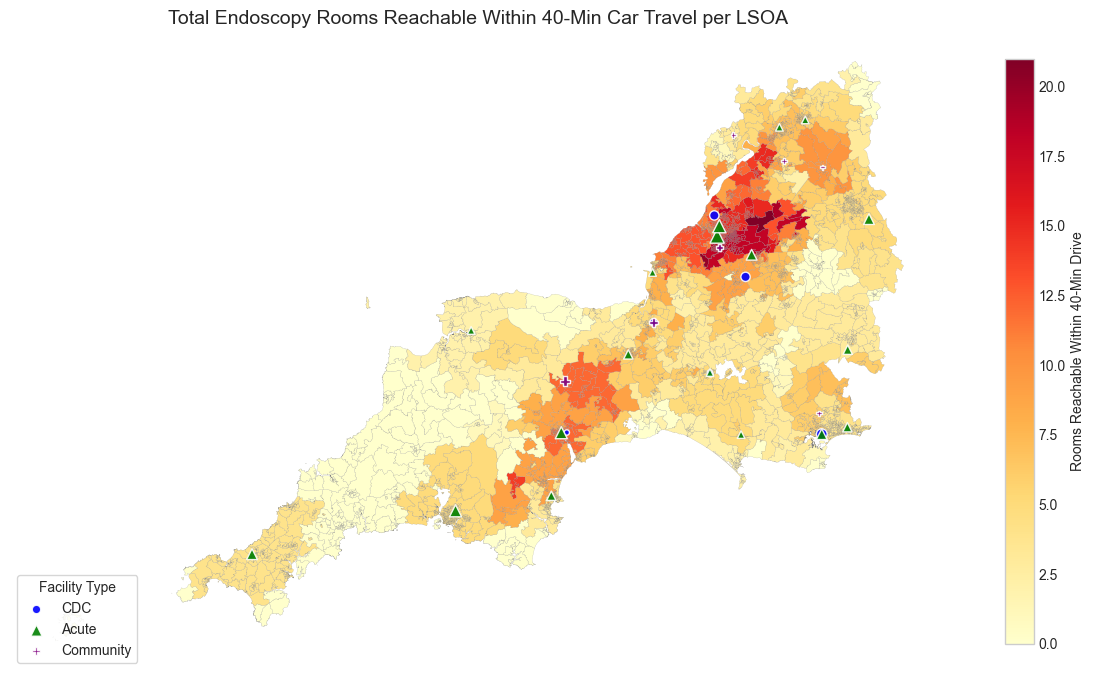

In [27]:
# ----------------------------------------------------------
# Step 5a – Plot Reachable Endoscopy Rooms Within 40-Min Car Travel
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Step 1: Aggregate reachable rooms per origin LSOA
rooms_within_40 = (
    travel_df_40
    .groupby("origin_name", as_index=False)
    .agg({
        "rooms_at_destination": "sum"
    })
    .rename(columns={
        "origin_name": "lsoa21cd",
        "rooms_at_destination": "reachable_rooms_40min"
    })
)

# Step 2: Join with LSOA geometries
lsoa_geom_merged = lsoa_gdf.merge(rooms_within_40, on="lsoa21cd", how="left")
lsoa_geom_merged["reachable_rooms_40min"] = lsoa_geom_merged["reachable_rooms_40min"].fillna(0)

# Step 3: Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot LSOAs by reachable room count
plot = lsoa_geom_merged.plot(
    column="reachable_rooms_40min",
    cmap="YlOrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Rooms Reachable Within 40-Min Drive", "shrink": 0.5},
    ax=ax
)

# Overlay facility markers
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# Final formatting
ax.set_title("Total Endoscopy Rooms Reachable Within 40-Min Car Travel per LSOA", fontsize=14)
ax.axis("off")
ax.legend(title="Facility Type", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()


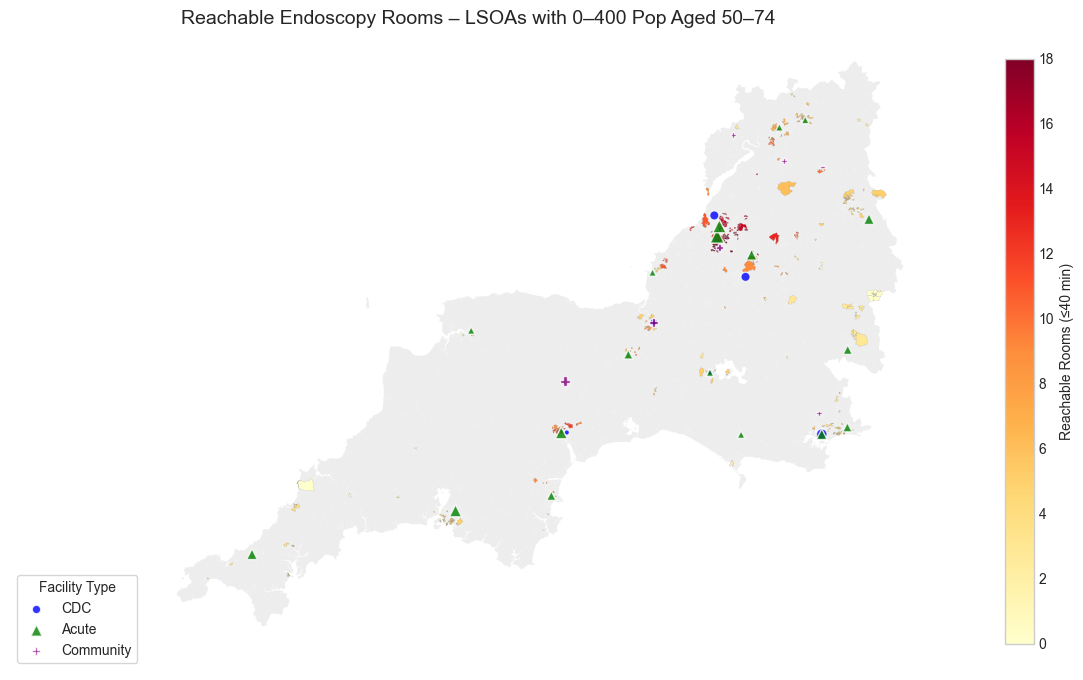

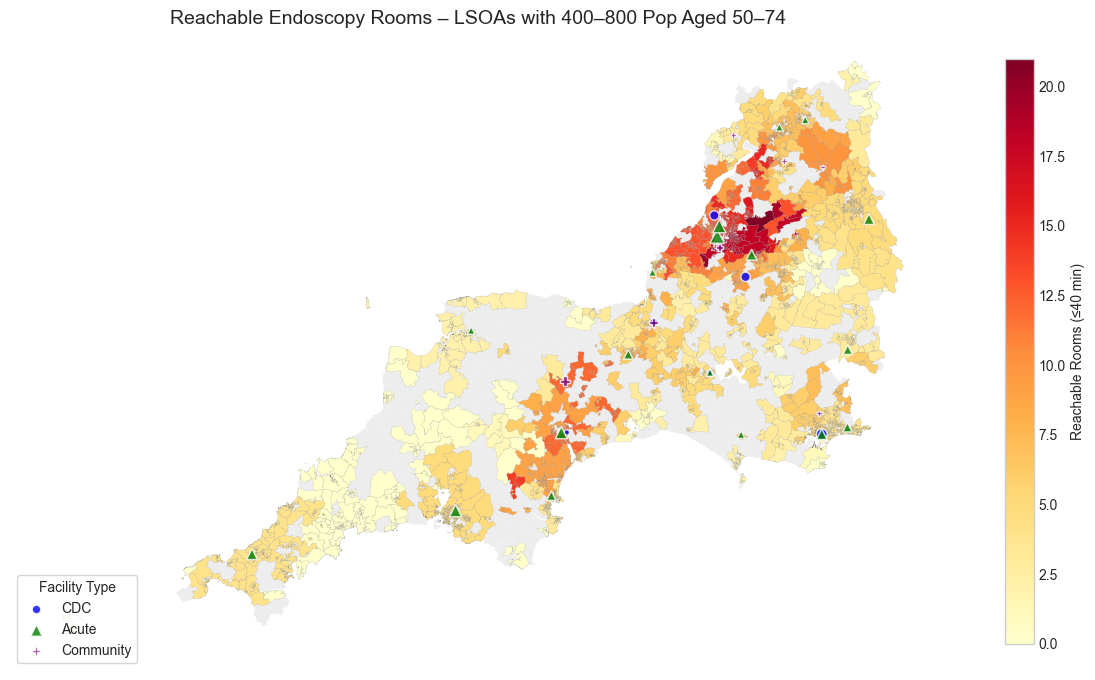

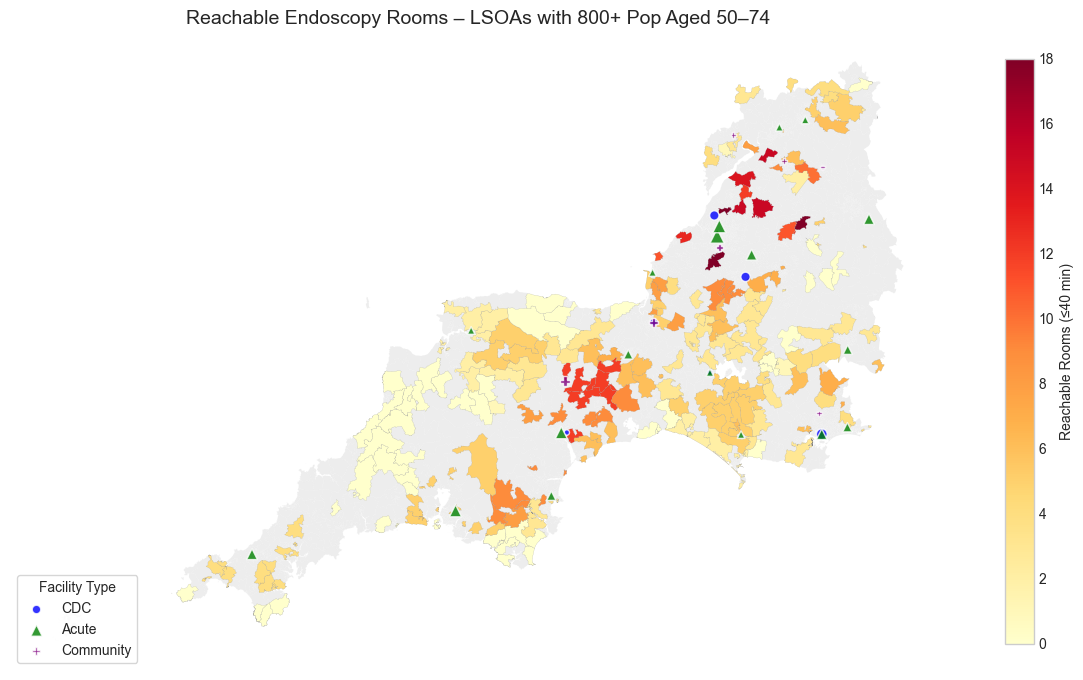

In [29]:
# ----------------------------------------------------------
# Step 5b – Show Reachable Rooms by LSOA Population Band (0–400, 400–800, 800+)
# ----------------------------------------------------------

# 1. Merge population into geometry with reachable rooms
lsoa_plot_gdf = (
    lsoa_gdf[["lsoa21cd", "geometry"]]
    .merge(lsoa_geom_merged[["lsoa21cd", "reachable_rooms_40min"]], on="lsoa21cd", how="left")
    .merge(lsoa_gdf[["lsoa21cd", "pop_50_74"]], on="lsoa21cd", how="left")
)

lsoa_plot_gdf["reachable_rooms_40min"] = lsoa_plot_gdf["reachable_rooms_40min"].fillna(0)
lsoa_plot_gdf["pop_50_74"] = lsoa_plot_gdf["pop_50_74"].fillna(0)

# 2. Define population bands
population_bands = [
    ("0–400", 0, 400),
    ("400–800", 400, 800),
    ("800+", 800, float("inf"))
]

# 3. Define plotting function
def plot_band(title_suffix, pop_min, pop_max):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Separate highlight and grey LSOAs
    highlight = lsoa_plot_gdf[(lsoa_plot_gdf["pop_50_74"] > pop_min) & (lsoa_plot_gdf["pop_50_74"] <= pop_max)]
    other = lsoa_plot_gdf[~lsoa_plot_gdf.index.isin(highlight.index)]
    
    # Grey out the rest
    other.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1, alpha=0.4)
    
    # Plot highlighted band with reachable rooms
    highlight.plot(
        ax=ax,
        column="reachable_rooms_40min",
        cmap="YlOrRd",
        linewidth=0.1,
        edgecolor="grey",
        legend=True,
        legend_kwds={"label": "Reachable Rooms (≤40 min)", "shrink": 0.5}
    )
    
    # Overlay facilities
    for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
        subset = facilities_gdf[facilities_gdf["source"] == label]
        subset.plot(
            ax=ax,
            color=colour,
            markersize=subset["Endoscopy Rooms"] * 15,
            marker=marker,
            label=label,
            alpha=0.8,
            edgecolor="white"
        )
    
    # Formatting
    ax.set_title(f"Reachable Endoscopy Rooms – LSOAs with {title_suffix} Pop Aged 50–74", fontsize=14)
    ax.axis("off")
    ax.legend(title="Facility Type", loc="lower left", frameon=True)
    plt.tight_layout()
    plt.show()

# 4. Plot all 3 bands
for label, pop_min, pop_max in population_bands:
    plot_band(label, pop_min, pop_max)


In [30]:
# ----------------------------------------------------------
# Step 6 – Competition-Adjusted Rooms per 100k (Catchment Pressure Logic)
# ----------------------------------------------------------

# 6.1 – Total population competing for each facility (destination LSOA)
facility_pop = (
    travel_df_40
    .groupby("destination_name", as_index=False)["pop_50_74"]
    .sum()
    .rename(columns={"pop_50_74": "competing_pop_50_74"})
)

# 6.2 – Merge competing population back into travel matrix
travel_df_40 = travel_df_40.merge(
    facility_pop,
    on="destination_name",
    how="left"
)

# 6.3 – Compute each facility’s contribution to origin LSOA, adjusted by demand competition
travel_df_40["room_contrib_per_100k"] = (
    travel_df_40["rooms_at_destination"] /
    travel_df_40["competing_pop_50_74"].replace(0, np.nan)
) * 100_000

# 6.4 – Aggregate competition-adjusted access score for each origin LSOA
competition_access = (
    travel_df_40
    .groupby("origin_name", as_index=False)["room_contrib_per_100k"]
    .sum()
    .rename(columns={
        "origin_name": "lsoa21cd",
        "room_contrib_per_100k": "rooms_per_100k_competition"
    })
)

# 6.5 – Apply access tier classification
def classify_access(x):
    if x < 3.5:
        return "Low"
    elif x < 4.0:
        return "Marginal"
    else:
        return "Adequate"

competition_access["access_flag"] = competition_access["rooms_per_100k_competition"].apply(classify_access)

# 6.6 – Confirm structure
print(f"Completed competition-based access scoring: {competition_access.shape[0]} LSOAs")
display(competition_access.head())
display(competition_access["access_flag"].value_counts())


Completed competition-based access scoring: 3179 LSOAs


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01014014,3.207243,Low
1,E01014031,1.011377,Low
2,E01014032,2.058137,Low
3,E01014036,3.207243,Low
4,E01014057,3.207243,Low


access_flag
Adequate    1314
Low         1057
Marginal     808
Name: count, dtype: int64

In [31]:
# ----------------------------------------------------------
# Step 7a – Merge Competition-Based Access Scores into LSOA Geometry
# ----------------------------------------------------------

lsoa_access_gdf = lsoa_gdf.merge(
    competition_access,
    on="lsoa21cd",
    how="left"
)

# Fill missing access values with 0 or 'Unknown' as appropriate
lsoa_access_gdf["rooms_per_100k_competition"] = lsoa_access_gdf["rooms_per_100k_competition"].fillna(0)
lsoa_access_gdf["access_flag"] = lsoa_access_gdf["access_flag"].fillna("Unknown")

# Check structure
print(f"GeoDataFrame merged: {lsoa_access_gdf.shape[0]} LSOAs")
display(lsoa_access_gdf[["lsoa21cd", "rooms_per_100k_competition", "access_flag"]].head())


GeoDataFrame merged: 3451 LSOAs


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01020484,0.0,Unknown
1,E01020481,0.0,Unknown
2,E01020482,0.0,Unknown
3,E01020479,0.0,Unknown
4,E01020478,0.0,Unknown


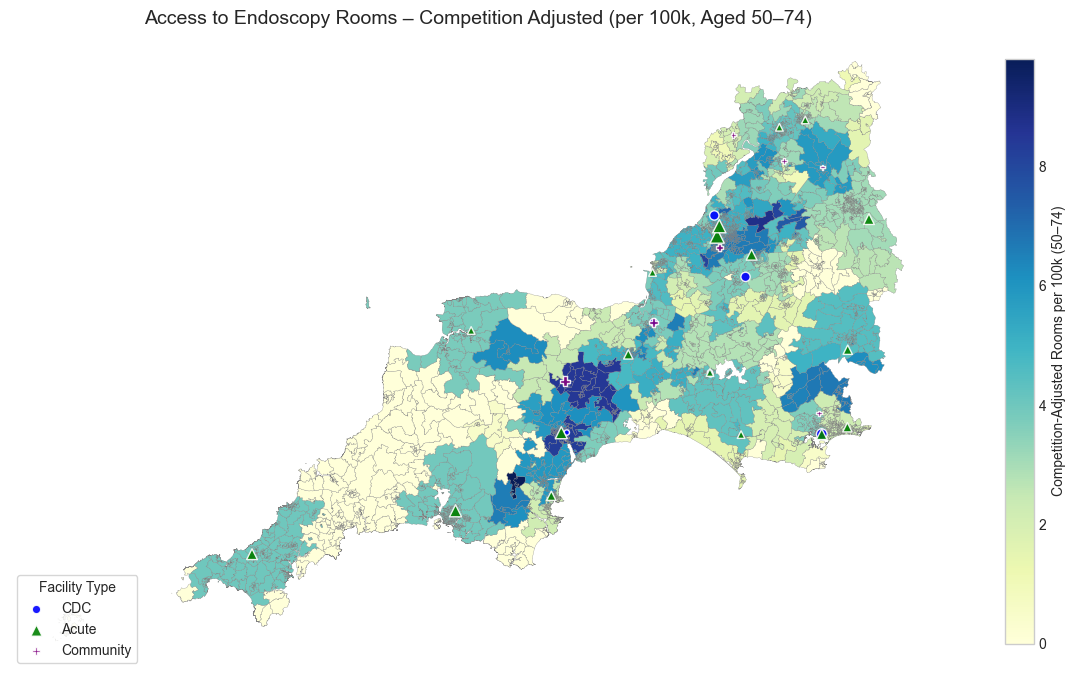

In [33]:
# ----------------------------------------------------------
# Step 7b – Choropleth: Rooms per 100k (Competition Adjusted)
# ----------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

lsoa_access_gdf.plot(
    column="rooms_per_100k_competition",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Competition-Adjusted Rooms per 100k (50–74)", "shrink": 0.5},
    ax=ax
)

# Overlay facility markers
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

ax.set_title("Access to Endoscopy Rooms – Competition Adjusted (per 100k, Aged 50–74)", fontsize=14)
ax.axis("off")
ax.legend(title="Facility Type", loc="lower left", frameon=True)
plt.tight_layout()
plt.show()


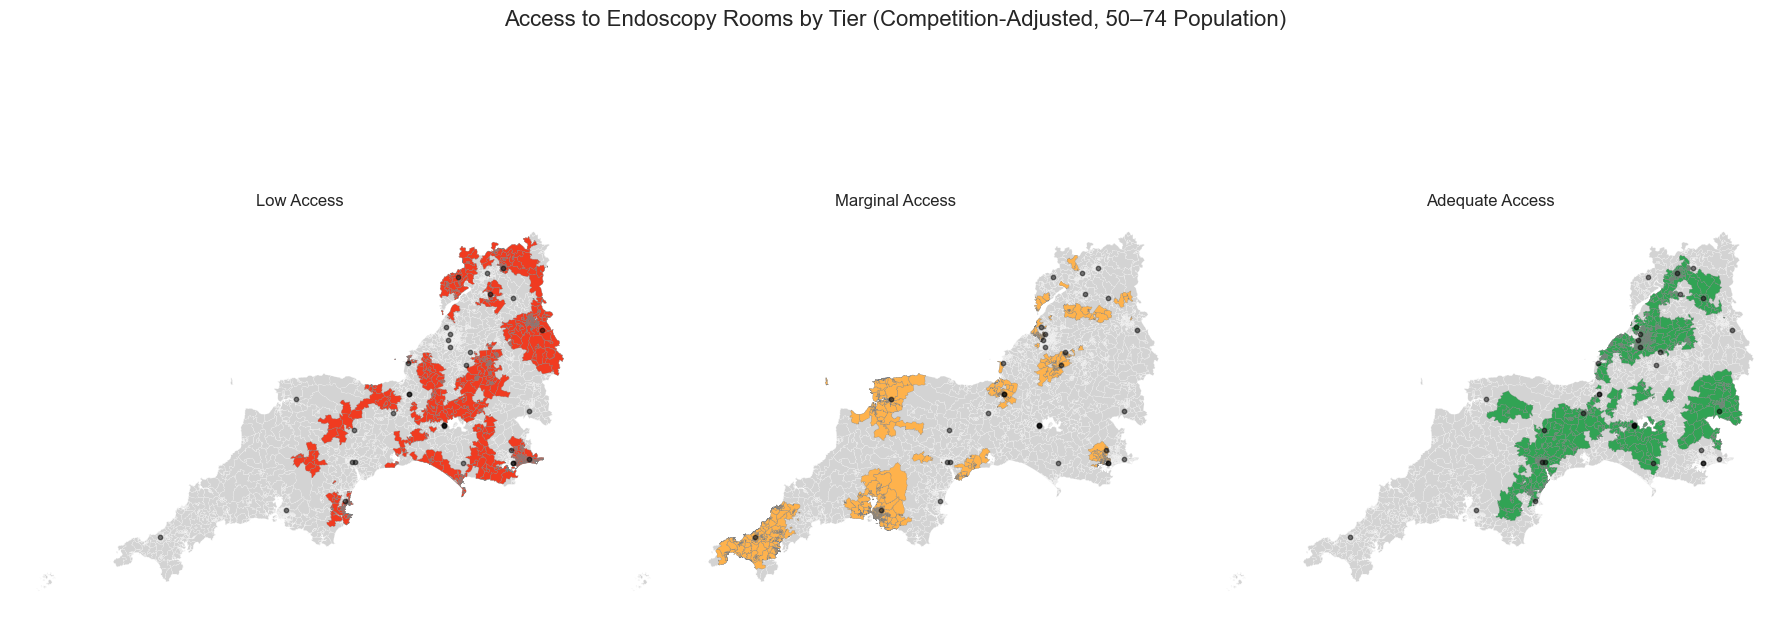

In [34]:
# ----------------------------------------------------------
# Step 7c – Subplots: Low / Marginal / Adequate Access Tiers
# ----------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

tier_order = ["Low", "Marginal", "Adequate"]
colours = ["#f03b20", "#feb24c", "#31a354"]

for i, tier in enumerate(tier_order):
    ax = axes[i]
    
    # All LSOAs greyed out
    lsoa_access_gdf.plot(
        color="lightgrey",
        linewidth=0.1,
        edgecolor="white",
        ax=ax
    )
    
    # Highlight selected tier
    lsoa_access_gdf[lsoa_access_gdf["access_flag"] == tier].plot(
        color=colours[i],
        linewidth=0.2,
        edgecolor="grey",
        ax=ax
    )
    
    # Overlay facilities
    facilities_gdf.plot(
        ax=ax,
        color="black",
        markersize=10,
        marker="o",
        alpha=0.5
    )

    ax.set_title(f"{tier} Access", fontsize=12)
    ax.axis("off")

plt.suptitle("Access to Endoscopy Rooms by Tier (Competition-Adjusted, 50–74 Population)", fontsize=16)
plt.tight_layout()
plt.show()


In [35]:
# ----------------------------------------------------------
# Step 8 – Export LSOA Competition Access Scores to Local Directory
# ----------------------------------------------------------

# Define export path
export_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/lsoa_competition_access.gpkg"

# Export as GeoPackage
lsoa_access_gdf.to_file(export_path, layer="access_scores", driver="GPKG")

print(f"Export complete → {export_path}")


Export complete → /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/lsoa_competition_access.gpkg
